# Infer ***endoplasmic reticulum (ER)*** - part 6️⃣

--------------
## **OBJECTIVE** 
### <input type="checkbox"/> Infer sub-cellular component  ***ER***  
Segment the ***ER*** from a single channel (membrane marker). This workflow was optimized for images of fluorescently tagged Sec61beta, a membrane protein. An instance segmentation is not done here as we assume the ER is one coninuous organelle.

---------------------
## infer ***ER***
### summary of steps 

➡️ **EXTRACTION**
- **`STEP 1`** - Select a channel for segmentation

    - select single channel containing the ER marker (channel number = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE-PROCESSING**
- **`STEP 3`** - Global + local thresholding (AICSSeg – MO)

    - apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

- **`STEP 4`** - ‘Filament’ threshold method (AICSSeg)

  - apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

- **`STEP 5`** - Combine Segmentations (logical or)

  - combine the two segmentations with logical *OR*

**POST-PROCESSING**
- **`STEP 6`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 7`** - Create one object (as unt16)

  - label all ER "objects" 1/True

**EXPORT** ➡️ 
- save labeled ***ER*** (ER) as unsigned integer 16-bit tif files


> ###### **The Allen Cell Segmenter procedure included an edge proserving smoothing method followed by the "filament" thresholding method (find the Sec61b script [here](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/structure_wrapper/seg_sec61b.py)). We have opted to also include to MO threshold method as it segments densely packed ER better**

---------------------
## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook.

In [2]:
# top level imports
from pathlib import Path
import os

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files)

from infer_subc.core.img import *
 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **LOAD AND READ IN IMAGE FOR PROCESSING**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [3]:
# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = ".tiff"

## Define the path to the directory that contains the input image folder.
data_root_path = Path(os.getcwd()).parents[1] / "sample_data" /  "example_neuron"

## Specify which subfolder that contains the input data
in_data_path = data_root_path / "raw"

## Specify the output folder
out_data_path = data_root_path / "seg"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

#### &#x1F3C3; **Run code; no user input required**

In [4]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

img_file_list = list_image_files(in_data_path,im_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [5]:
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

# ***EXTRACTION prototype - ER***

## **`STEP 1` - Select a channel for segmentation**

- select single channel containing the ER marker (channel number = user input)

In [6]:
###################
# INPUT
###################
ER_CH = 1
raw_ER = select_channel_from_raw(img_data, ER_CH)

# ***PRE-PROCESSING prototype - ER***

## **`STEP 2` - Rescale and smooth image**

- rescale intensity of composite image (min=0, max=1)
- median filter (median size = user input)
- gaussian filter (sigma = user input)

In [7]:
###################
# PRE_PROCESSING
###################
median_sz = 0
gauss_sig = 0

struct_img = scale_and_smooth(raw_ER,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)

# ***CORE-PROCESSING prototype - ER***

## **`STEP 3` - Global + local thresholding (AICSSeg – MO)**

- apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

In [8]:
###################
# CORE_PROCESSING
###################
# segment the ER with this global and local thresholding method
thresh_method = 'tri'
cell_wise_min_area = 1200
thresh_adj = 0.5

bw_MO_test = masked_object_thresh(struct_img,
                          global_method=thresh_method, 
                          cutoff_size=cell_wise_min_area, 
                          local_adjust=thresh_adj)

## **`STEP 4` - ‘Filament’ threshold method (AICSSeg)**

- apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

In [9]:
# apply the 2D or 3D versions of the AICSsegmentation filament filter with multiple scales
fil_scale_1 = .5
fil_cut_1 = 0.001

fil_scale_2 = 1
fil_cut_2 = 0.001

fil_scale_3 = 0
fil_cut_3 = 0

fil_method = "3D"

bw_filament_test = filament_filter_3(struct_img,
                                    fil_scale_1,
                                    fil_cut_1,
                                    fil_scale_2,
                                    fil_cut_2,
                                    fil_scale_3,
                                    fil_cut_3,
                                    fil_method)

## **`STEP 5`- Combine Segmentations (logical or)**

- combine the two segmentations with logical *OR*

In [10]:
# combine the two segmentations together
bw_test = np.logical_or(bw_MO_test, bw_filament_test)

# ***POST-PROCESSING prototype - ER***

## **`STEP 6` - Remove small holes and objects**

- fill holes (hole size = user input)
- remove small objects (object size = user input)
- filter method (method = user input)

In [11]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 0

small_object_width = 1

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_test, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# ***POST-POST-PROCESSING prototype - ER***

> ###### We assume that the ER is one continuous object.

## **`STEP 7` - Create one object (as unt16)**

- label all ER "objects" 1/True

In [12]:
###################
# LABELING
###################
ER_labels = label_bool_as_uint16(cleaned_img2)

In [13]:
ER_labels.dtype

dtype('uint16')

## **Visualize with `napari` 1**
Visualize the first-pass segmentation and labeling with `napari`.

In [14]:
viewer = napari.Viewer(title = "ER",
                       ndisplay=3)

In [15]:
viewer.add_image(
    struct_img,
    scale = scale,
    name = "ER Intensities")

viewer.add_image(
    cleaned_img2,
    scale = scale,
    opacity=0.3,
    name = "ER Segmentation")

viewer.add_labels(
    ER_labels,
    scale = scale,
    opacity=0.3,
    name = "ER Labels")

<Labels layer 'ER Labels' at 0x234d3ef0d00>

# ***EXTRACTION prototype - ER***

- save labeled ***ER*** (ER) as unsigned integer 16-bit tif files

In [16]:
out_file_n = export_inferred_organelle(ER_labels, "ER", meta_dict, out_data_path)

saved file: 20230727_C2-121_conditioned_well 4_cell 3_untreated_Linear unmixing_0_cmle.ome-ER


In [17]:
# Whether or not to include the segmentation in the batch processing performed in part 2 of infer-subc (quantification)
to_batch = True
if to_batch:
    out_file_b = export_inferred_organelle(ER_labels,
                                           "ER",
                                           meta_dict,
                                           Path(os.getcwd()).parents[1] / "sample_data" /  "batch_example" / "seg")

saved file: 20230727_C2-121_conditioned_well 4_cell 3_untreated_Linear unmixing_0_cmle.ome-ER


## **Define `_infer_ER` function**

> ###### **📝 these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use**

In [18]:
##########################
#  infer_ER
##########################
def _infer_ER(
              in_img: np.ndarray,
              ER_ch: int,
              median_sz: int,
              gauss_sig: float,
              MO_thresh_method: str,
              MO_cutoff_size: float,
              MO_thresh_adj: float,
              fil_scale_1: float,
              fil_cut_1: float,
              fil_scale_2: float, 
              fil_cut_2: float, 
              fil_scale_3: float, 
              fil_cut_3: float,
              fil_method: str,
              min_hole_w: int,
              max_hole_w: int,
              small_obj_w: int,
              fill_filter_method: str
              ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    filament_scale: 
        scale (log_sigma) for filament filter
    filament_cut: 
        threshold for filament fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # EXTRACT
    ###################    
    ER = select_channel_from_raw(in_img, ER_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    # er = normalized_edge_preserving_smoothing(er)
    struct_img =  scale_and_smooth(ER,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)

    ###################
    # CORE_PROCESSING
    ###################
    bw1 = masked_object_thresh(struct_img, 
                                    global_method=MO_thresh_method, 
                                    cutoff_size=MO_cutoff_size, 
                                    local_adjust=MO_thresh_adj)

    bw2 = filament_filter_3(struct_img, fil_scale_1, fil_cut_1, fil_scale_2, fil_cut_2, fil_scale_3, fil_cut_3, fil_method)

    struct_obj = np.logical_or(bw1, bw2)
    
    ###################
    # POST_PROCESSING
    ################### 
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    
    # ENSURE THAT there is ONLY ONE ER
    struct_obj = label_bool_as_uint16(struct_obj)

    return struct_obj 

# **Test  `_infer_ER` function**

In [19]:
_ER_object =  _infer_ER(
        img_data,
        ER_CH,
        median_sz,
        gauss_sig,
        thresh_method,
        cell_wise_min_area,
        thresh_adj,
        fil_scale_1,
        fil_cut_1,
        fil_scale_2,
        fil_cut_2,
        fil_scale_3,
        fil_cut_3,
        fil_method,
        hole_min_width,
        hole_max_width,
        small_object_width,
        fill_filter_method)

_ER_object.dtype

dtype('uint16')

In [20]:
np.all(ER_labels == _ER_object)

True

## **Visualize with `napari` 2**

In [21]:
viewer.add_image(
    _ER_object,
    scale = scale,
    opacity=0.3,
    colormap='hsv')

<Image layer '_ER_object' at 0x23615aa89a0>

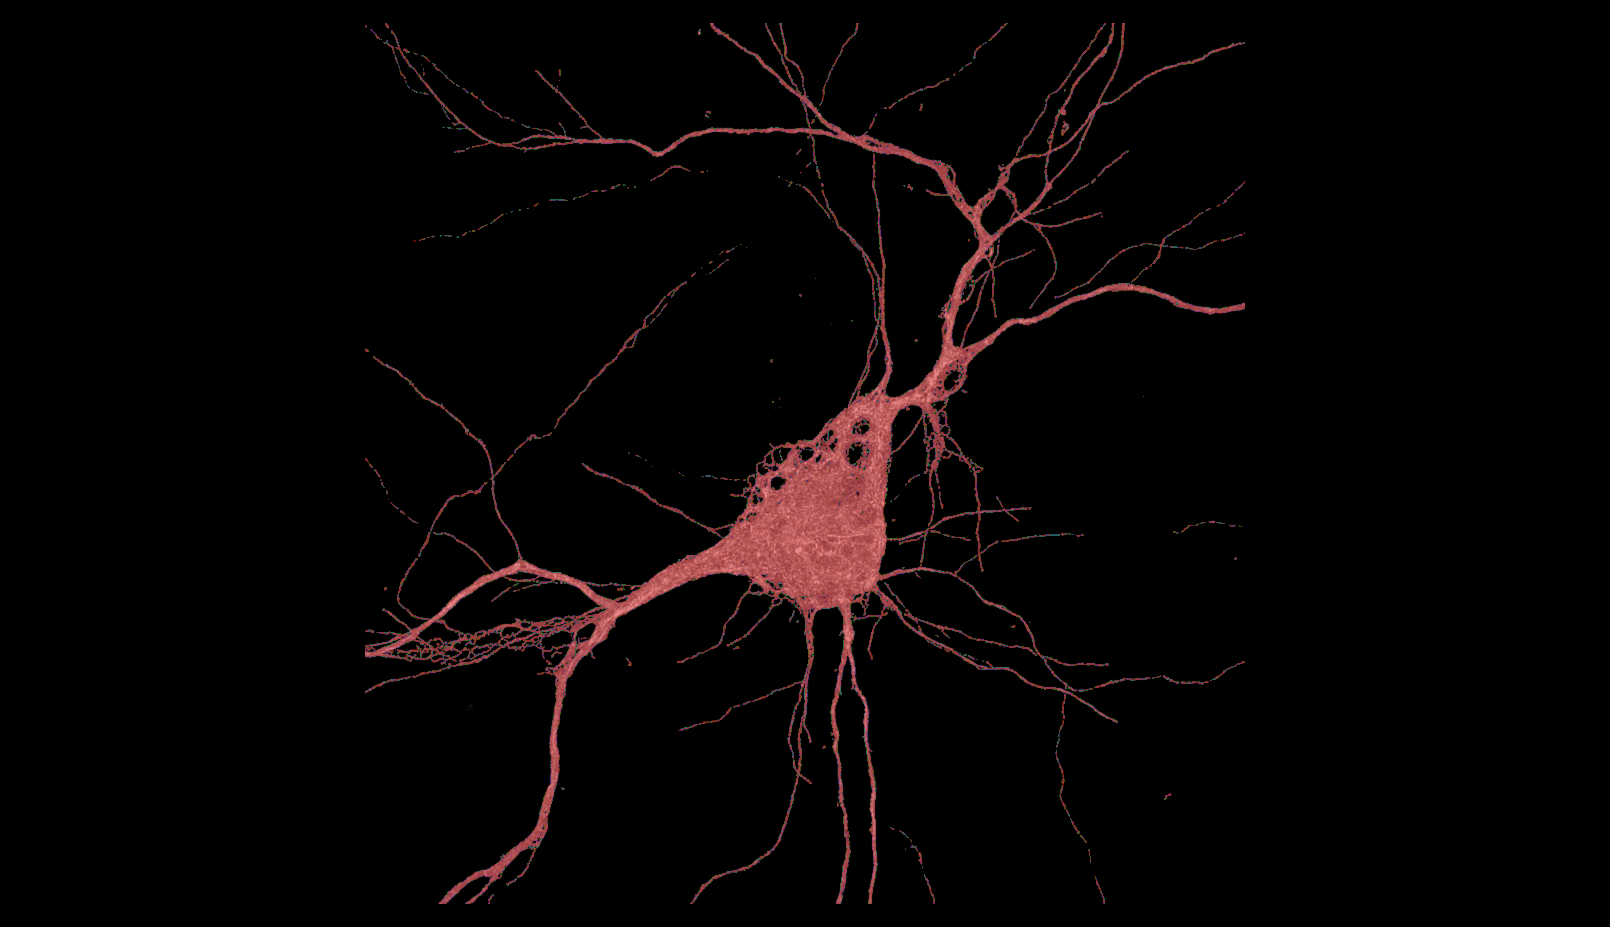

In [22]:
nbscreenshot(viewer, canvas_only=True)

In [23]:
viewer.close()

-------------
### NEXT: INFER LIPID DROPLET

proceed to [1.7_infer_lipid_droplet.ipynb](./1.7_infer_lipid_droplet.ipynb)
